Model fitting 2: SSC + galaxy template
======================================


In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
import jetset
from jetset.test_data_helper import  test_SEDs
from jetset.data_loader import ObsData,Data
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs


In [2]:
print(jetset.__version__)

1.3.0rc7


In [3]:
test_SEDs

['/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_3C345.ecsv',
 '/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk421_EBL_DEABS.ecsv',
 '/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_ABS.ecsv',
 '/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_DEABS.ecsv']

## Loading data



In [4]:
data=Data.from_file(test_SEDs[3])



***  binning data  ***
---> N bins= 90
---> bin_widht= 0.2
msk [False  True False  True  True  True  True  True False False False  True
 False False False False False False False False False False False False
 False  True  True  True  True  True  True False False False False False
 False False  True  True  True  True False  True  True  True  True  True
  True False  True False False False False False False False False False
 False False False False False False  True False  True False  True False
  True False  True False  True False False False False False  True  True
  True  True  True  True  True False]



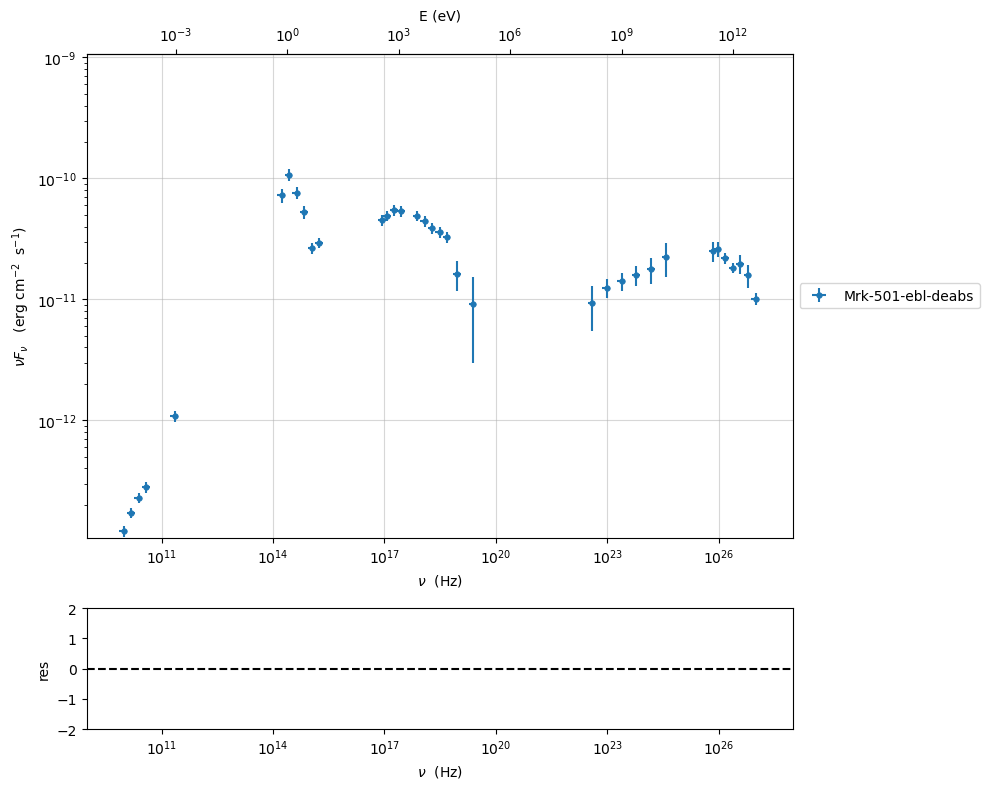

In [5]:
%matplotlib inline
sed_data=ObsData(data_table=data)
sed_data.group_data(bin_width=0.2)

sed_data.add_systematics(0.1,[10.**6,10.**29])
p=sed_data.plot_sed()

In [6]:
sed_data.save('Mrk_501.pkl')

## Phenomenological model constraining

### Spectral indices


*** evaluating spectral indices for data ***



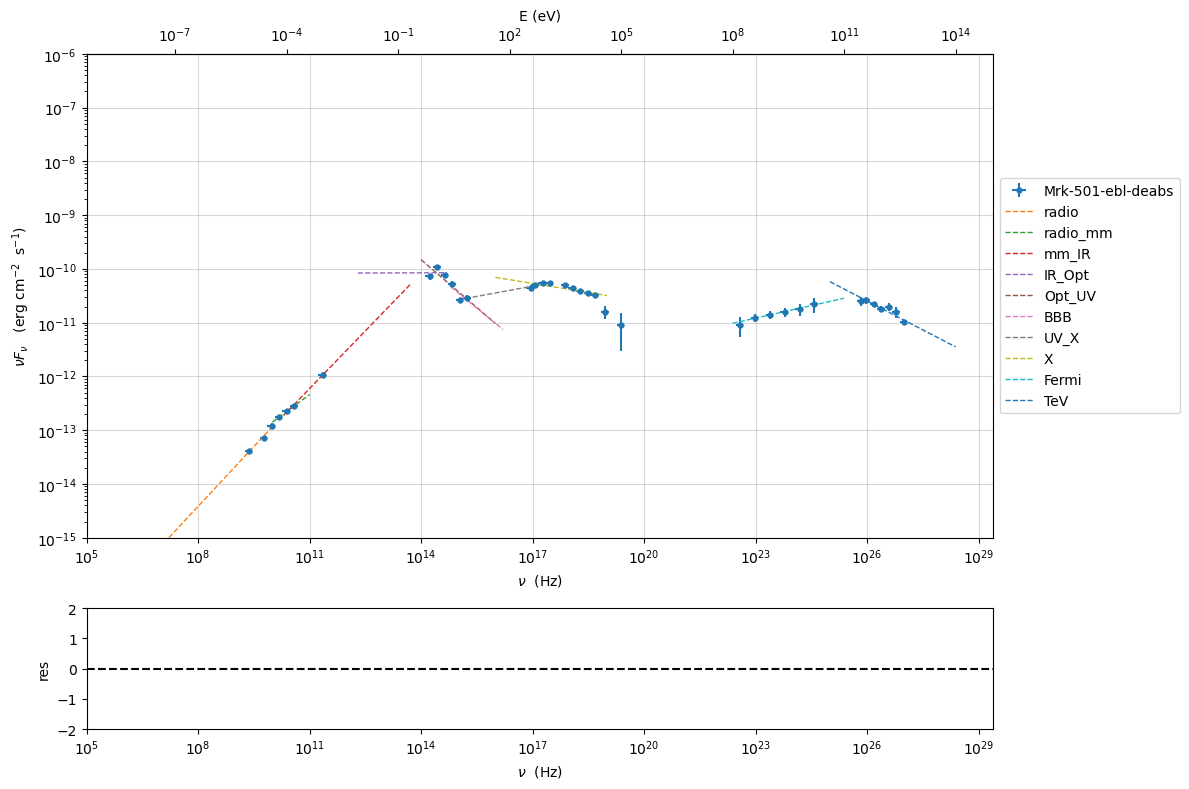

In [7]:
from jetset.sed_shaper import  SEDShape
my_shape=SEDShape(sed_data)
my_shape.eval_indices(silent=True)
p=my_shape.plot_indices()
p.setlim(y_min=1E-15,y_max=1E-6)

### Sed shaper

In [8]:
mm,best_fit=my_shape.sync_fit(check_host_gal_template=True,
  Ep_start=None,
  minimizer='lsb',
  silent=True,
  fit_range=[10. , 21.])


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [10.0, 21.0]
---> class:  HSP

---> class:  HSP




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-6.522794e-02,-6.522794e-02,5.892905e-03,--,-4.913172e-02,-1.000000e+01,0.000000e+00,False
LogCubic,c,-1.908748e-03,-1.908748e-03,8.488797e-04,--,5.440153e-03,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,1.704833e+01,1.704833e+01,6.858392e-02,--,1.593204e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.030052e+01,-1.030052e+01,1.424853e-02,--,-1.022242e+01,-3.000000e+01,0.000000e+00,False
host_galaxy,nuFnu_p_host,-1.008538e+01,-1.008538e+01,2.900917e-02,--,-1.022242e+01,-1.222242e+01,-8.222416e+00,False
host_galaxy,nu_scale,1.934519e-02,1.934519e-02,1.919833e-03,--,0.000000e+00,-5.000000e-01,5.000000e-01,False


---> sync       nu_p=+1.704833e+01 (err=+6.858392e-02)  nuFnu_p=-1.030052e+01 (err=+1.424853e-02) curv.=-6.522794e-02 (err=+5.892905e-03)




*** Log-Polynomial fitting of the IC component ***
---> fit range: [23.0, 29.0]
---> LogCubic fit
====> simplex
====> migrad
====> simplex
====> migrad
====> simplex
====> migrad




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.323324e-01,-1.323324e-01,3.154579e-02,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-3.389147e-02,-3.389147e-02,2.022657e-02,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,2.550950e+01,2.550950e+01,2.190510e-01,--,2.555059e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.057957e+01,-1.057957e+01,4.198643e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> IC         nu_p=+2.550950e+01 (err=+2.190510e-01)  nuFnu_p=-1.057957e+01 (err=+4.198643e-02) curv.=-1.323324e-01 (err=+3.154579e-02)



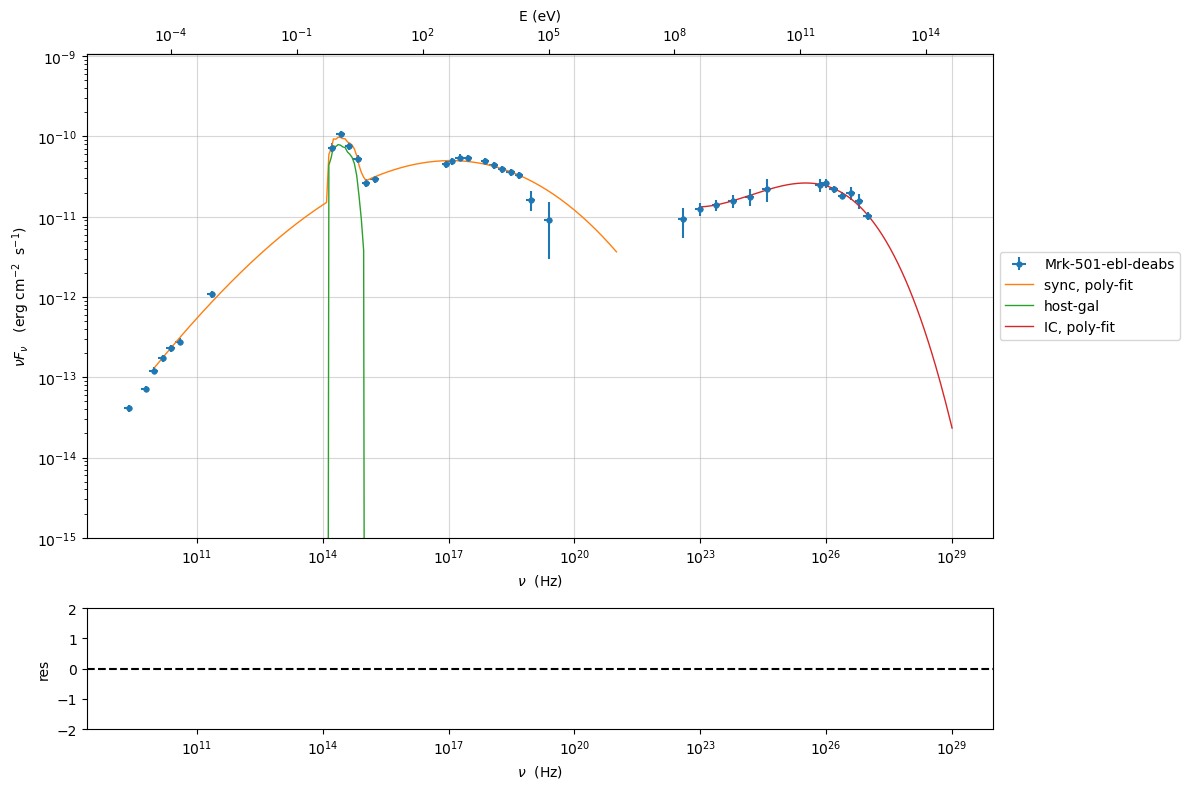

In [9]:
my_shape.IC_fit(fit_range=[23., 29.],minimizer='minuit',silent=True)
p=my_shape.plot_shape_fit()
p.setlim(y_min=1E-15)

### Model constraining

In this step we are not fitting the model, we are just obtaining the phenomenological `pre_fit` model, that will be fitted in using minuit ore least-square bound, as shown below

In [10]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
from jetset.minimizer import fit_SED
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='lppl',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E11,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet_gal_templ.pkl')


***  constrains parameters from observable ***

===> setting C threads to 12


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,1.141280e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.360000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.487509e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.312656e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.107634e+04,1.000000e+00,1.000000e+09,False,False


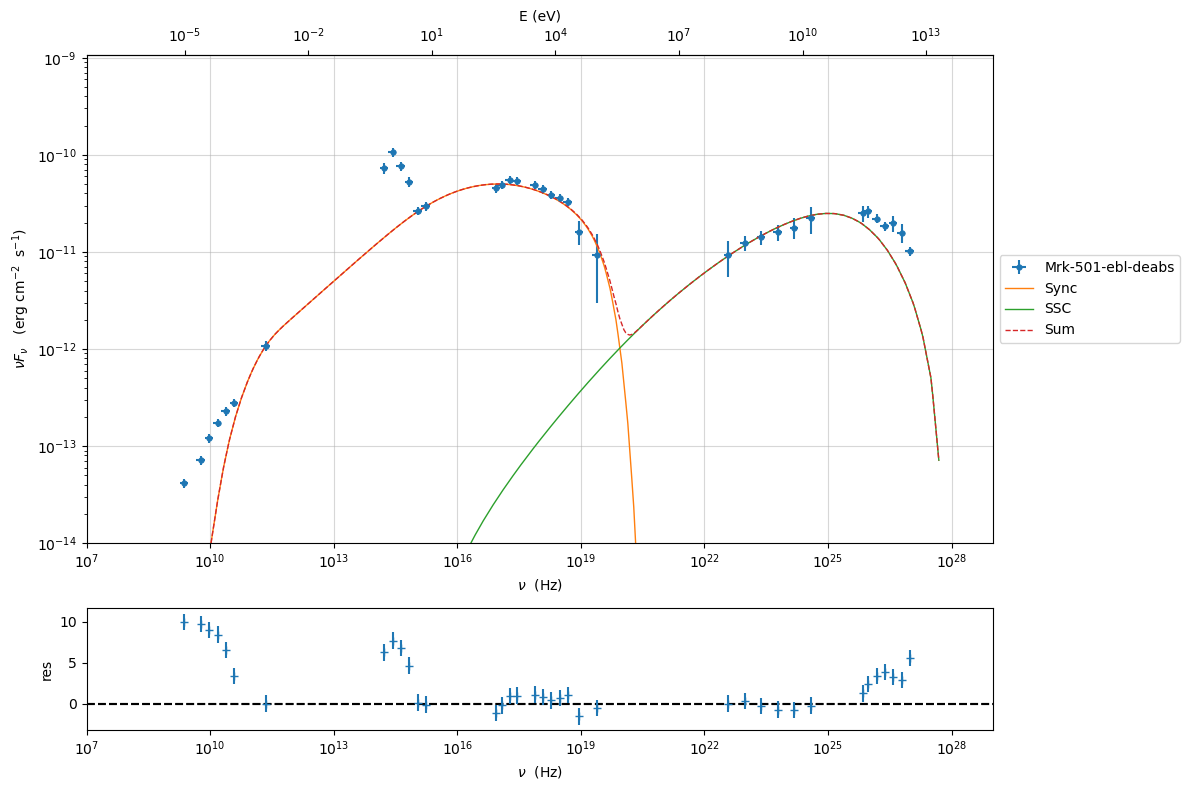

In [11]:
pl=prefit_jet.plot_model(sed_data=sed_data)
pl.add_residual_plot(prefit_jet,sed_data)
pl.setlim(y_min=1E-14,x_min=1E7,x_max=1E29)

## Model fitting procedure

### Model fitting with LSB

In [15]:
from jetset.model_manager import  FitModel
from jetset.jet_model import Jet

jet=Jet.load_model('prefit_jet_gal_templ.pkl')
jet.set_gamma_grid_size(200)

===> setting C threads to 12


In [16]:
fit_model=FitModel( jet=jet, name='SSC-best-fit-lsb',template=my_shape.host_gal) 
fit_model.show_model()


--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: SSC-best-fit-lsb  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet
 -model name: host_galaxy model type: template

--------------------------------------------------------------------------------
individual component description

--------------------------------------------------------------------------------
model description: 
--------------------------------------------------------------------------------
type: Jet
name: jet_leptonic  
geometry: spherical  

electrons distribution:
 type: lppl  
 gamma energy grid size:  201
 gmin grid : 1.487509e+02
 gmax grid : 2.310708e+06
 normalization:  True
 log-values:  False
 ratio of cold protons to relativistic electrons: 1.000000e+00

radiative fields:
 seed photons grid size:  100
 IC emission grid size:  

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.487509e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.312656e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.107634e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.248426e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,3.261397e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.141280e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True


--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
model description
--------------------------------------------------------------------------------
name: host_galaxy  
type: template  

--------------------------------------------------------------------------------


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
host_galaxy,nuFnu_p_host,nuFnu-scale,erg / (s cm2),-1.008538e+01,-2.000000e+01,2.000000e+01,False,False
host_galaxy,nu_scale,nu-scale,Hz,1.934519e-02,-2.000000e+00,2.000000e+00,False,True


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [17]:
fit_model.composite_expr='jet_leptonic + host_galaxy'

In [18]:
fit_model.freeze('jet_leptonic','z_cosm')
fit_model.freeze('jet_leptonic','R_H')
fit_model.jet_leptonic.parameters.N.fit_range=[1E-5, 1E5]
fit_model.jet_leptonic.parameters.B.fit_range=[1E-3, 1]

fit_model.jet_leptonic.parameters.beam_obj.fit_range=[5., 50.]
fit_model.jet_leptonic.parameters.R.fit_range=[1E15,1E17]
fit_model.jet_leptonic.parameters.gmax.fit_range=[1E4,1E8]
fit_model.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model.host_galaxy.parameters.nu_scale.frozen=True

In [19]:
from jetset.minimizer import fit_SED,ModelMinimizer

model_minimizer_lsb=ModelMinimizer('lsb')
best_fit_lsb=model_minimizer_lsb.fit(fit_model,sed_data,1E11,1E29,fitname='SSC-best-fit-lsb',repeat=1)

filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 31

*** start fit process ***
----- 


0it [00:00, ?it/s]

- best chisq=4.16923e+01

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-lsb


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,8.580927e+01,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,5.244887e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.069947e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.220278e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,2.813492e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.141280e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,3.716188e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True



converged=True
calls=429
mesg=


'`ftol` termination condition is satisfied.'

dof=21
chisq=41.692309, chisq/red=1.985348 null hypothesis sig=0.004599

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,8.580927e+01,8.580927e+01,2.245405e+02,--,1.487509e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,2.310708e+06,2.310708e+06,3.063708e+06,--,2.310708e+06,1.000000e+04,1.000000e+08,False
jet_leptonic,N,5.244887e+01,5.244887e+01,3.642249e+02,--,2.312656e+01,1.000000e-05,1.000000e+05,False
jet_leptonic,gamma0_log_parab,1.069947e+04,1.069947e+04,1.593138e+04,--,1.107634e+04,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.220278e+00,2.220278e+00,6.119317e-02,--,2.248426e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,2.813492e-01,2.813492e-01,6.199616e-02,--,3.261397e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,1.141280e+16,1.141280e+16,4.323108e+16,--,1.141280e+16,1.000000e+15,1.000000e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,3.716188e-02,3.716188e-02,4.850783e-02,--,5.050000e-02,1.000000e-03,1.000000e+00,False
jet_leptonic,NH_cold_to_rel_e,1.000000e+00,--,--,--,1.000000e+00,0.000000e+00,--,True


-------------------------------------------------------------------------




In [20]:
best_fit_lsb.save_report('SSC-best-fit-lsb.pkl')
model_minimizer_lsb.save_model('model_minimizer_lsb.pkl')
fit_model.save_model('fit_model_lsb.pkl')

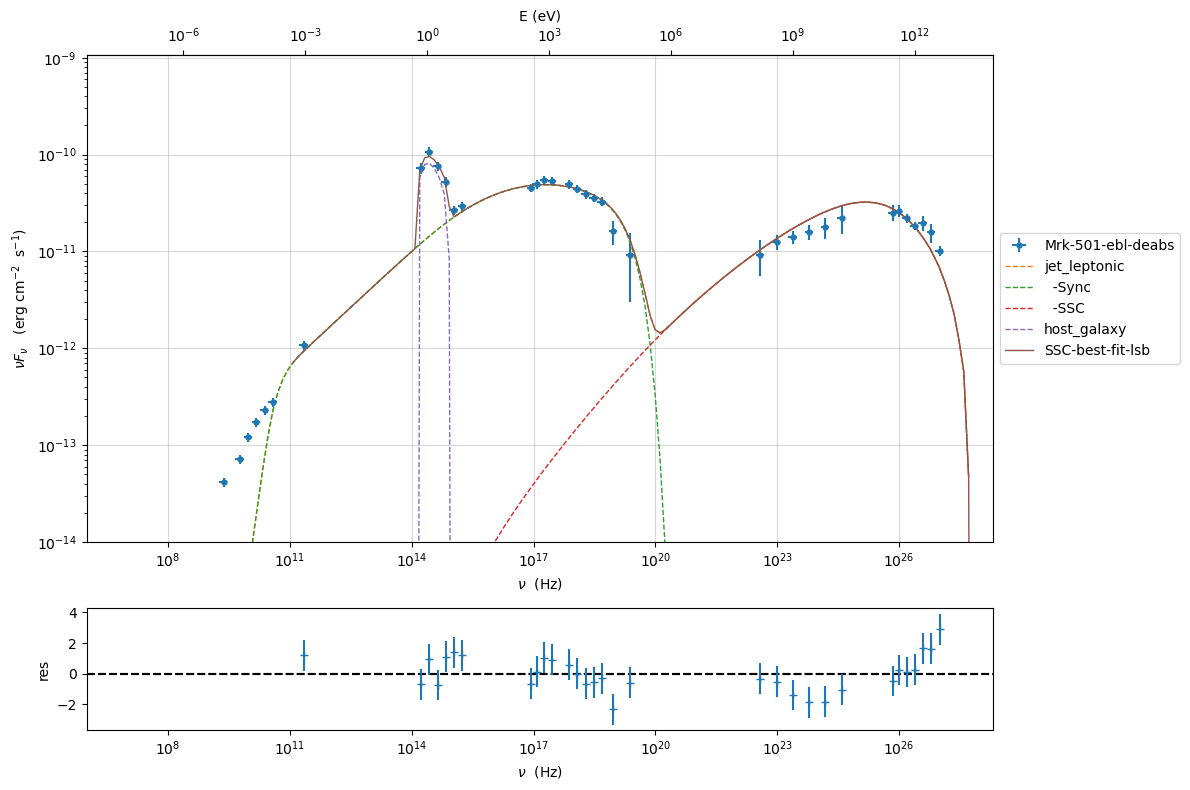

In [21]:
%matplotlib inline
fit_model.set_nu_grid(1E6,1E30,200)
fit_model.eval()
p2=fit_model.plot_model(sed_data=sed_data)
p2.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

### Model fitting with Minuit

To run the ``minuit`` minimizer we will use the best-fit results from ``lsb`` to set the boundaries for our parameters. 

In [22]:
fit_model.freeze('jet_leptonic','z_cosm')
fit_model.freeze('jet_leptonic','R_H')
fit_model.jet_leptonic.parameters.beam_obj.fit_range=[5., 50.]
fit_model.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model.host_galaxy.parameters.nu_scale.frozen=True
fit_model.jet_leptonic.parameters.gmin.fit_range=[10,1000]
fit_model.jet_leptonic.parameters.gmax.fit_range=[5E5,1E8]
fit_model.jet_leptonic.parameters.gamma0_log_parab.fit_range=[1E3,5E5]



In [23]:
model_minimizer_minuit=ModelMinimizer('minuit')
best_fit_minuit=model_minimizer_minuit.fit(fit_model,sed_data,1E11,1E29,fitname='SSC-best-fit-minuit',repeat=3)

filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 31

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

====> simplex
====> migrad
- best chisq=1.04513e+01

fit run: 1
- old chisq=1.04513e+01


0it [00:00, ?it/s]

====> simplex
====> migrad
- best chisq=1.04509e+01

fit run: 2
- old chisq=1.04509e+01


0it [00:00, ?it/s]

====> simplex
====> migrad
- best chisq=1.04509e+01

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-minuit


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,5.455560e+01,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.105148e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,4.504764e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,5.386110e+03,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.168634e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,2.323139e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.298307e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.206137e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True



converged=True
calls=1019
mesg=


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 10.45                      │             Nfcn = 1019              │
│ EDM = 1.19e-05 (Goal: 0.0002)    │           time = 27.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0 │   54.56   │   0.27    │            │            │   10    │  1000   │       │
│ 1 │ par_1 │  2.11e6   │  0.17e6   │            │            │ 500000  │  1e+08  │       │
│ 2 │ par_2 │   45.0    │    0.4    │            │            │  1e-05  │ 100000  │       │
│ 3 │ par_3 │  5.39e3   │  0.08e3   │            │            │  1000   │ 500000  │       │
│ 4 │ par_4 │   2.169   │   0.004   │            │            │   -10   │   10    │       │
│ 5 │ par_5 │ 232.3e-3  │  0.8e-3   │            │            │   -15   │   15    │       │
│ 6 │ par_6 │ 12.983e15 │ 0.033e15  │            │            │3.16228e+15│3.16228e+17│       │
│ 7 │ par_7 │ 12.06e-3  │  0.09e-3  │            │            │  0.001  │    1    │       │
│ 8 │ par_8 │   47.64   │   0.17    │            │            │    5    │   50    │       │
│ 9 │ par_9 │  -10.085  │   0.020   │            │            │-12.2224 │-8.22242 │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

dof=21
chisq=10.450851, chisq/red=0.497660 null hypothesis sig=0.972444

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,5.455560e+01,5.455560e+01,2.726560e-01,--,8.580927e+01,1.000000e+01,1.000000e+03,False
jet_leptonic,gmax,2.105148e+06,2.105148e+06,1.675281e+05,--,2.310708e+06,5.000000e+05,1.000000e+08,False
jet_leptonic,N,4.504764e+01,4.504764e+01,4.131515e-01,--,5.244887e+01,1.000000e-05,1.000000e+05,False
jet_leptonic,gamma0_log_parab,5.386110e+03,5.386110e+03,7.892077e+01,--,1.069947e+04,1.000000e+03,5.000000e+05,False
jet_leptonic,s,2.168634e+00,2.168634e+00,3.851834e-03,--,2.220278e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,2.323139e-01,2.323139e-01,7.857833e-04,--,2.813492e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,1.298307e+16,1.298307e+16,3.259461e+13,--,1.141280e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.206137e-02,1.206137e-02,8.551352e-05,--,3.716188e-02,1.000000e-03,1.000000e+00,False
jet_leptonic,NH_cold_to_rel_e,1.000000e+00,--,--,--,1.000000e+00,0.000000e+00,--,True


-------------------------------------------------------------------------




for further information regardin minuit please refer to https://iminuit.readthedocs.io/en/stable/

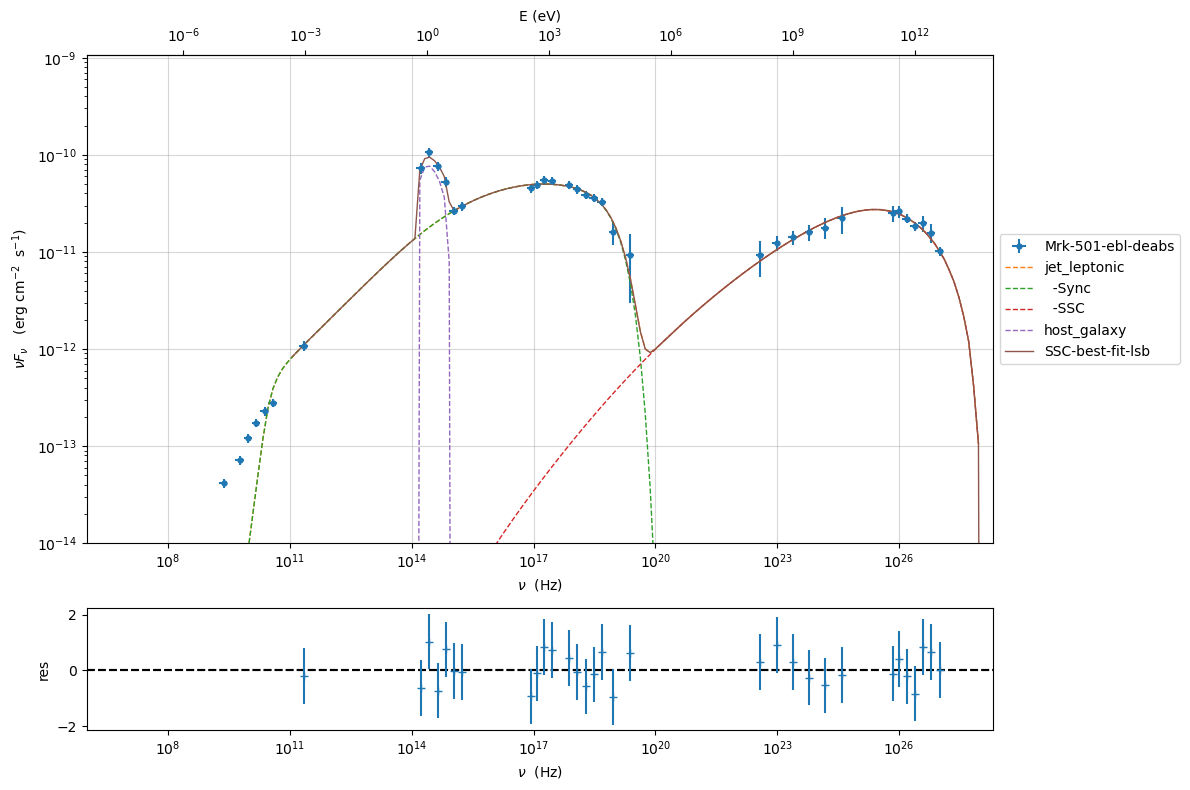

In [24]:
%matplotlib inline
fit_model.set_nu_grid(1E6,1E30,200)
fit_model.eval()
p2=fit_model.plot_model(sed_data=sed_data)
p2.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

In [25]:
best_fit_minuit.save_report('SSC-best-fit-minuit.pkl')
model_minimizer_minuit.save_model('model_minimizer_minuit.pkl')
fit_model.save_model('fit_model_minuit.pkl')

### Model fitting with a bkn pl


In [26]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
from jetset.minimizer import fit_SED
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='bkn',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E11,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet_bkn_gal_templ.pkl')


***  constrains parameters from observable ***

===> setting C threads to 12


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,1.247372e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,2.847716e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.360000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.980875e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,3.077106e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.406682e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,2.094216e+05,1.000000e+00,1.000000e+09,False,False


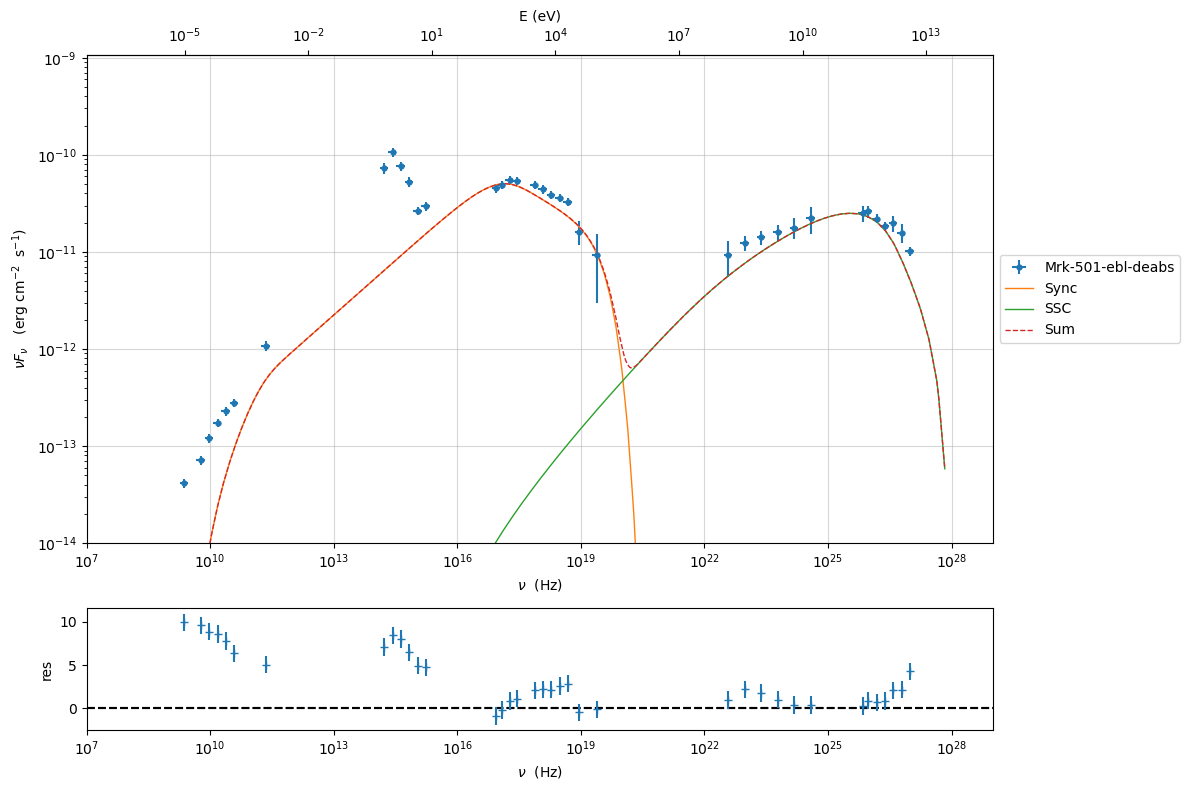

In [27]:
pl=prefit_jet.plot_model(sed_data=sed_data)
pl.add_residual_plot(prefit_jet,sed_data)
pl.setlim(y_min=1E-14,x_min=1E7,x_max=1E29)

In [28]:
jet_minuit_bkn=Jet.load_model('prefit_jet_bkn_gal_templ.pkl')
jet_minuit_bkn.set_gamma_grid_size(200)

fit_model_bkn=FitModel( jet=jet_minuit_bkn, name='SSC-best-fit-bkn-lsb',template=my_shape.host_gal) 


fit_model_bkn.freeze('jet_leptonic','z_cosm')
fit_model_bkn.freeze('jet_leptonic','R_H')
fit_model_bkn.jet_leptonic.parameters.beam_obj.fit_range=[5,50]
fit_model_bkn.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_bkn.jet_leptonic.parameters.gmax.fit_range=[1E4,1E8]
fit_model_bkn.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_bkn.host_galaxy.parameters.nu_scale.frozen=True



===> setting C threads to 12


In [29]:
model_minimizer_lsb_bkn=ModelMinimizer('lsb')
best_fit_lsb_bkn=model_minimizer_lsb_bkn.fit(fit_model_bkn,sed_data,1E11,1E29,fitname='SSC-best-fit-lsb')


filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 31

*** start fit process ***
----- 


0it [00:00, ?it/s]

- best chisq=2.49214e+01

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-lsb


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.485242e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,3.071765e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.629672e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,8.193745e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.262508e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,3.169331e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,R,region_size,cm,1.247372e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.430585e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True



converged=True
calls=482
mesg=


'`ftol` termination condition is satisfied.'

dof=21
chisq=24.921362, chisq/red=1.186732 null hypothesis sig=0.250586

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,1.485242e+02,1.485242e+02,1.195436e+02,--,1.980875e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,3.071765e+06,3.071765e+06,1.921033e+06,--,3.077106e+06,1.000000e+04,1.000000e+08,False
jet_leptonic,N,1.629672e+01,1.629672e+01,2.985576e+01,--,1.406682e+01,0.000000e+00,--,False
jet_leptonic,gamma_break,8.193745e+04,8.193745e+04,5.261749e+04,--,2.094216e+05,1.000000e+00,1.000000e+09,False
jet_leptonic,p,2.262508e+00,2.262508e+00,3.933694e-02,--,2.248426e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,p_1,3.169331e+00,3.169331e+00,4.793906e-02,--,3.500000e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,R,1.247372e+16,1.247372e+16,2.236984e+16,--,1.247372e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.430585e-02,1.430585e-02,1.084428e-02,--,2.847716e-02,0.000000e+00,--,False
jet_leptonic,NH_cold_to_rel_e,1.000000e+00,--,--,--,1.000000e+00,0.000000e+00,--,True


-------------------------------------------------------------------------




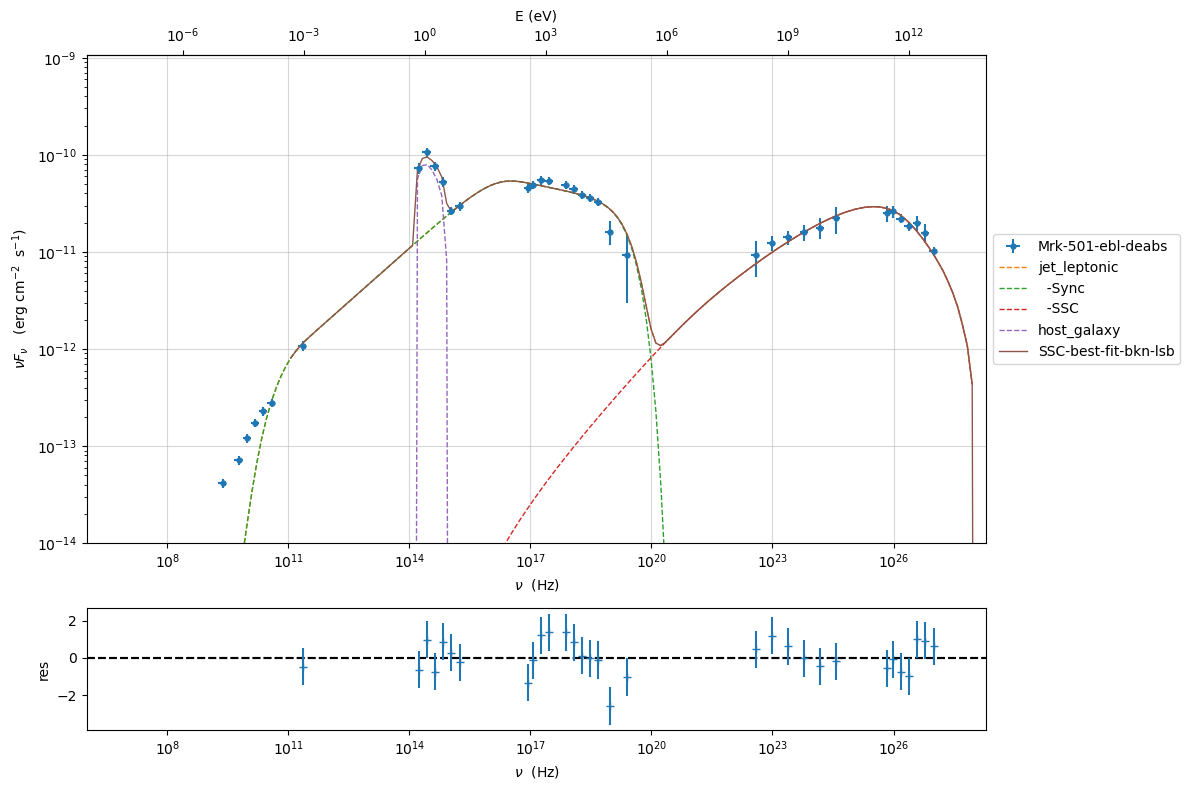

In [30]:
%matplotlib inline
fit_model_bkn.set_nu_grid(1E6,1E30,200)
fit_model_bkn.eval()
p2=fit_model_bkn.plot_model(sed_data=sed_data)
p2.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

In [31]:

fit_model_bkn.jet_leptonic.parameters.beam_obj.fit_range=[5,50]
fit_model_bkn.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_bkn.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_bkn.host_galaxy.parameters.nu_scale.frozen=True
fit_model_bkn.jet_leptonic.parameters.gmin.fit_range=[10,1000]
fit_model_bkn.jet_leptonic.parameters.gmax.fit_range=[5E5,1E8]
fit_model_bkn.jet_leptonic.parameters.gamma_break.fit_range=[1E3,1E6]
fit_model_bkn.jet_leptonic.parameters.p.fit_range=[1,3]
fit_model_bkn.jet_leptonic.parameters.p_1.fit_range=[2,5]


model_minimizer_minuit_bkn=ModelMinimizer('minuit')
best_fit_minuit_bkn=model_minimizer_minuit.fit(fit_model_bkn,sed_data,1E11,1E29,fitname='SSC-best-fit-minuit-bkn',repeat=3)

filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 31

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

====> simplex
====> migrad
- best chisq=1.34228e+01

fit run: 1
- old chisq=1.34228e+01


0it [00:00, ?it/s]

====> simplex
====> migrad
- best chisq=1.30362e+01

fit run: 2
- old chisq=1.30362e+01


0it [00:00, ?it/s]

====> simplex
====> migrad
- best chisq=1.30275e+01

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-minuit-bkn


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.345014e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.773731e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.625170e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,5.531173e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.248959e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,2.952674e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,R,region_size,cm,1.464854e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.349383e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True



converged=True
calls=1353
mesg=


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 13.03                      │             Nfcn = 1353              │
│ EDM = 5.33e-06 (Goal: 0.0002)    │           time = 27.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0 │  134.501  │   0.019   │            │            │   10    │  1000   │       │
│ 1 │ par_1 │ 1.7737e6  │ 0.0011e6  │            │            │ 500000  │  1e+08  │       │
│ 2 │ par_2 │  16.2517  │  0.0009   │            │            │    0    │         │       │
│ 3 │ par_3 │ 55.312e3  │  0.032e3  │            │            │  1000   │  1e+06  │       │
│ 4 │ par_4 │ 2.248959  │ 0.000020  │            │            │    1    │    3    │       │
│ 5 │ par_5 │  2.95267  │  0.00015  │            │            │    2    │    5    │       │
│ 6 │ par_6 │ 14.65e15  │  0.05e15  │            │            │3.16228e+15│3.16228e+17│       │
│ 7 │ par_7 │ 13.494e-3 │ 0.010e-3  │            │            │    0    │         │       │
│ 8 │ par_8 │   41.29   │   0.11    │            │            │    5    │   50    │       │
│ 9 │ par_9 │  -10.072  │   0.015   │            │            │-12.2224 │-8.22242 │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

dof=21
chisq=13.027500, chisq/red=0.620357 null hypothesis sig=0.907658

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,1.345014e+02,1.345014e+02,1.935667e-02,--,1.485242e+02,1.000000e+01,1.000000e+03,False
jet_leptonic,gmax,1.773731e+06,1.773731e+06,1.129851e+03,--,3.071765e+06,5.000000e+05,1.000000e+08,False
jet_leptonic,N,1.625170e+01,1.625170e+01,8.522217e-04,--,1.629672e+01,0.000000e+00,--,False
jet_leptonic,gamma_break,5.531173e+04,5.531173e+04,3.220423e+01,--,8.193745e+04,1.000000e+03,1.000000e+06,False
jet_leptonic,p,2.248959e+00,2.248959e+00,2.045150e-05,--,2.262508e+00,1.000000e+00,3.000000e+00,False
jet_leptonic,p_1,2.952674e+00,2.952674e+00,1.524221e-04,--,3.169331e+00,2.000000e+00,5.000000e+00,False
jet_leptonic,R,1.464854e+16,1.464854e+16,5.023364e+13,--,1.247372e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.349383e-02,1.349383e-02,1.023312e-05,--,1.430585e-02,0.000000e+00,--,False
jet_leptonic,NH_cold_to_rel_e,1.000000e+00,--,--,--,1.000000e+00,0.000000e+00,--,True


-------------------------------------------------------------------------




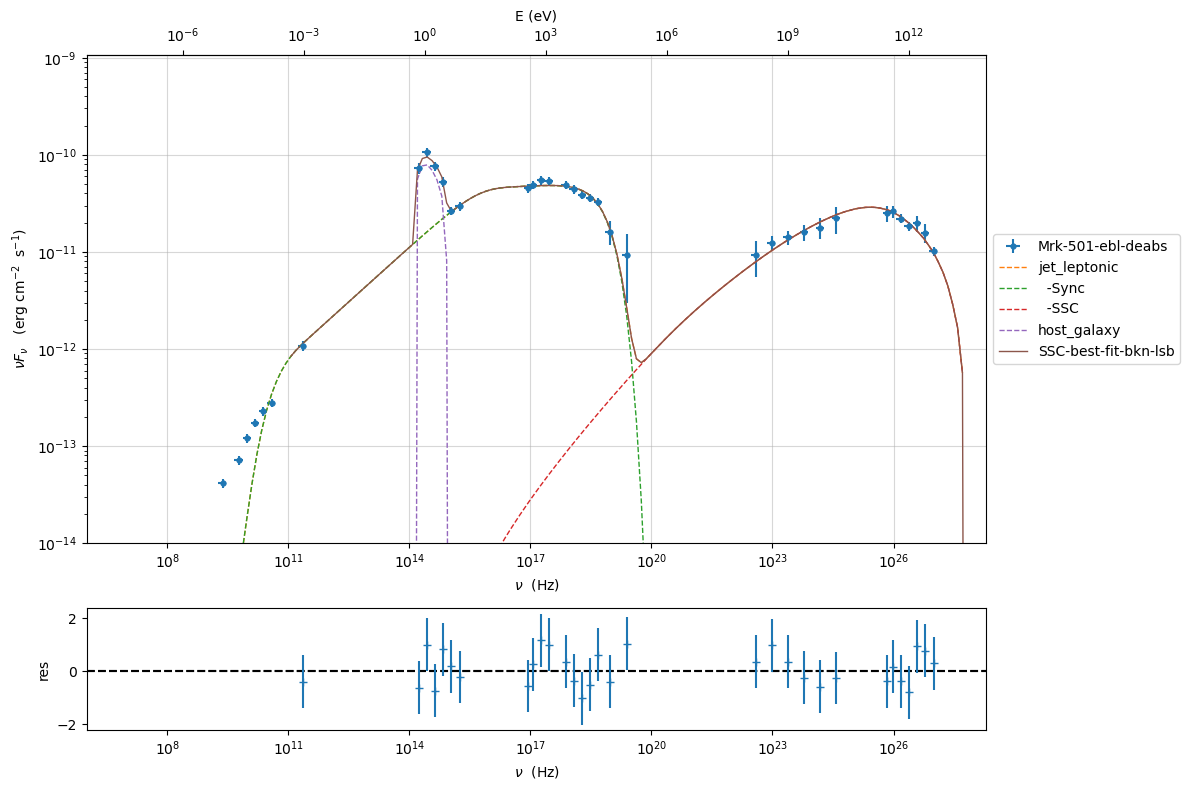

In [32]:
%matplotlib inline
fit_model_bkn.set_nu_grid(1E6,1E30,200)
fit_model_bkn.eval()
p2=fit_model_bkn.plot_model(sed_data=sed_data)
p2.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

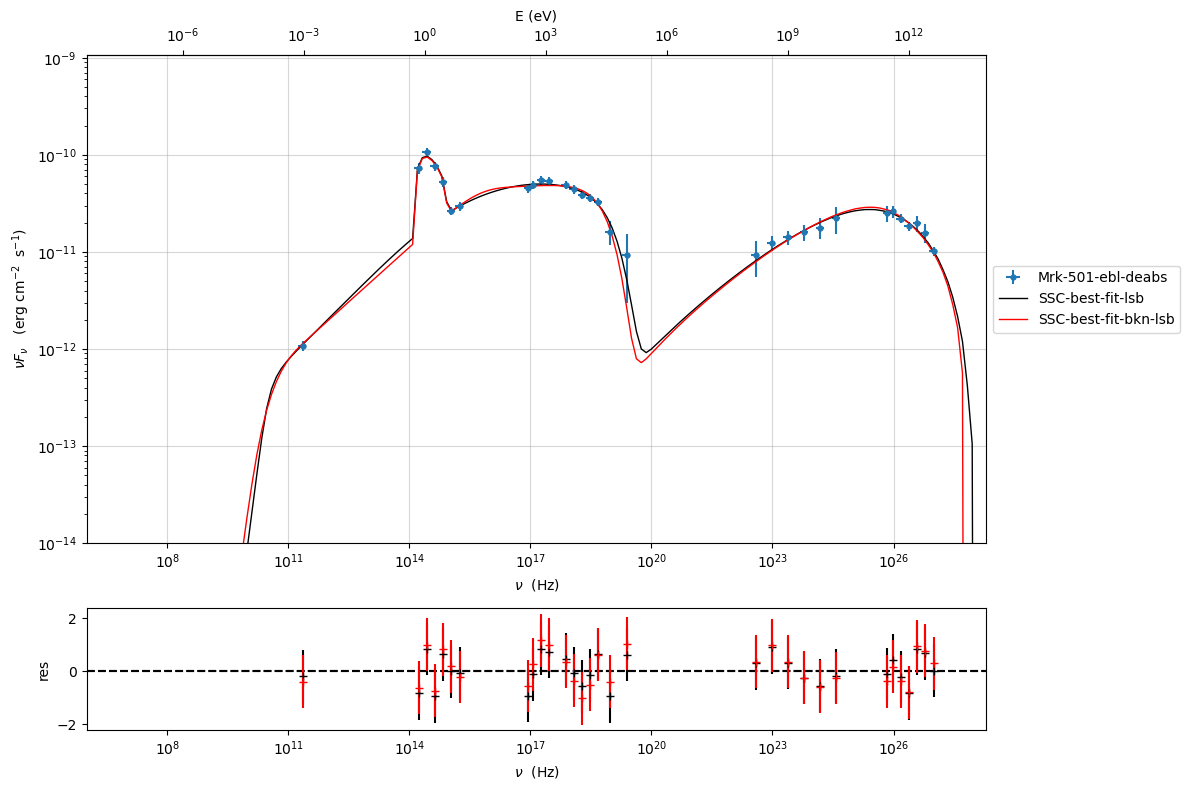

In [33]:
%matplotlib inline
from jetset.plot_sedfit import PlotSED
fit_model_bkn.set_nu_grid(1E6,1E30,200)
fit_model_bkn.eval()
fit_model.set_nu_grid(1E6,1E30,200)
fit_model.eval()

p2=PlotSED()
p2.add_data_plot(sed_data,fit_range=[ 1E11, 1E29])
p2.add_model_plot(fit_model,color='black')
p2.add_residual_plot(fit_model,sed_data,fit_range=[ 1E11, 1E29],color='black')
p2.add_model_plot(fit_model_bkn,color='red')
p2.add_residual_plot(fit_model_bkn,sed_data,fit_range=[ 1E11, 1E29],color='red')
p2.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

## MCMC sampling

In [38]:
from jetset.mcmc import McmcSampler
from jetset.minimizer import ModelMinimizer


In [39]:
model_minimizer_lsb = ModelMinimizer.load_model('model_minimizer_minuit.pkl')

mcmc=McmcSampler(model_minimizer_lsb)

===> setting C threads to 12


In [40]:
labels=['N','B','beam_obj','s','gamma0_log_parab']
model_name='jet_leptonic'
use_labels_dict={model_name:labels}
mcmc.set_labels(use_labels_dict=use_labels_dict)

In [41]:
mcmc.set_bounds(bound=5.0,bound_rel=True)

par: N  best fit value:  45.0476406721727  mcmc bounds: [1e-05, 270.2858440330362]
par: B  best fit value:  0.012061365634053165  mcmc bounds: [0.001, 0.07236819380431898]
par: beam_obj  best fit value:  47.638299687949946  mcmc bounds: [5.0, 50.0]
par: s  best fit value:  2.1686339157854624  mcmc bounds: [-8.67453566314185, 10]
par: gamma0_log_parab  best fit value:  5386.109843065869  mcmc bounds: [1000.0, 32316.659058395213]


In [42]:
mcmc.run_sampler(nwalkers=20, burnin=50,steps=500,progress='notebook')

===> setting C threads to 12
mcmc run starting



  0%|          | 0/500 [00:00<?, ?it/s]

mcmc run done, with 1 threads took 215.38 seconds


In [43]:
print(mcmc.acceptance_fraction)

0.4015000000000001


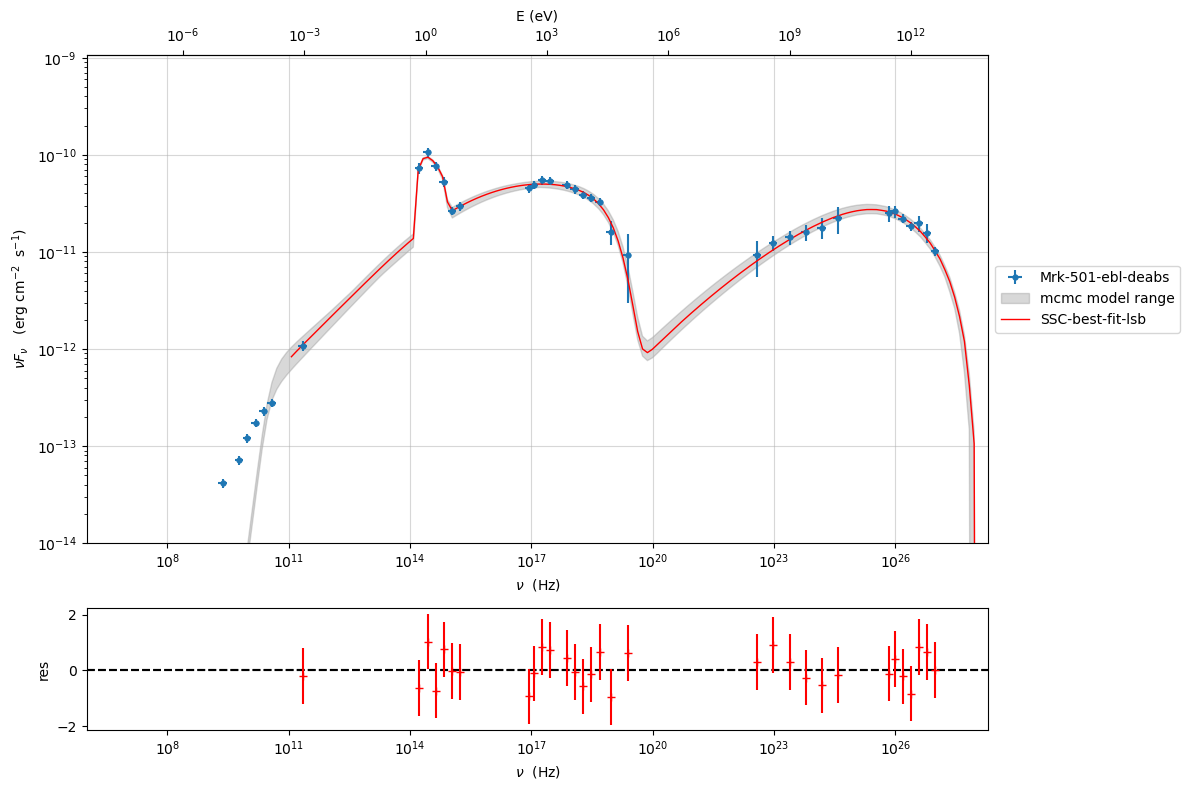

In [44]:
mcmc.model.jet_leptonic.nu_min=1E6
mcmc.model.nu_min=1E6
p=mcmc.plot_model(sed_data=sed_data,fit_range=[1E11, 2E28],size=100)
p.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

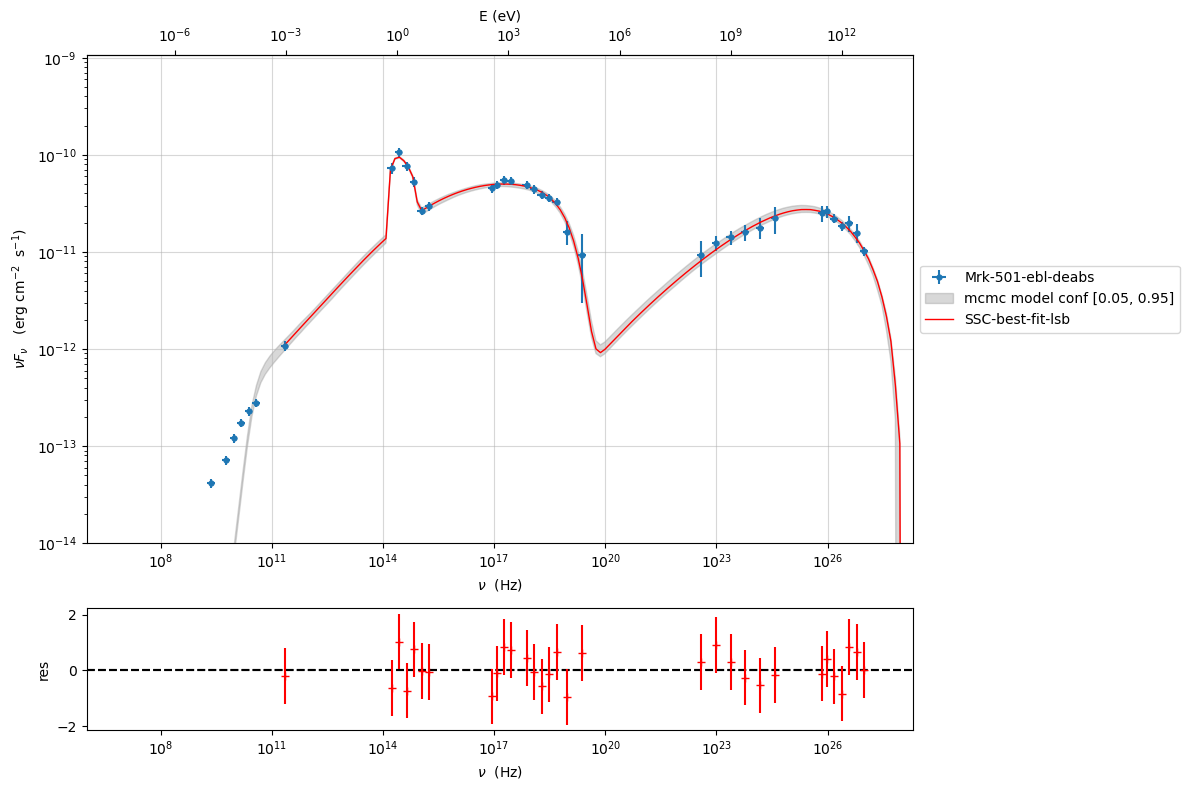

In [45]:
p=mcmc.plot_model(sed_data=sed_data,fit_range=[2E11, 2E28],quantiles=[0.05,0.95])
p.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

In [46]:
mcmc.labels

['N', 'B', 'beam_obj', 's', 'gamma0_log_parab']

To have a better rendering on the scatter plot, we redefine the plot labels

In [47]:
mcmc.set_plot_label('N',r'$N$')
mcmc.set_plot_label('B',r'$B$')
mcmc.set_plot_label('beam_obj',r'$\delta$')
mcmc.set_plot_label('s',r'$s$')
mcmc.set_plot_label('gamma0_log_parab',r'$\gamma_0$')

the code below lets you tuning the output:

 1) mpl.rcParams['figure.dpi'] if you increase it you get a better definition
 2) title_fmt=".2E" this is the format for python, 2 significant digits, scientific notation
 3) title_kwargs=dict(fontsize=12) you can change the fontsize


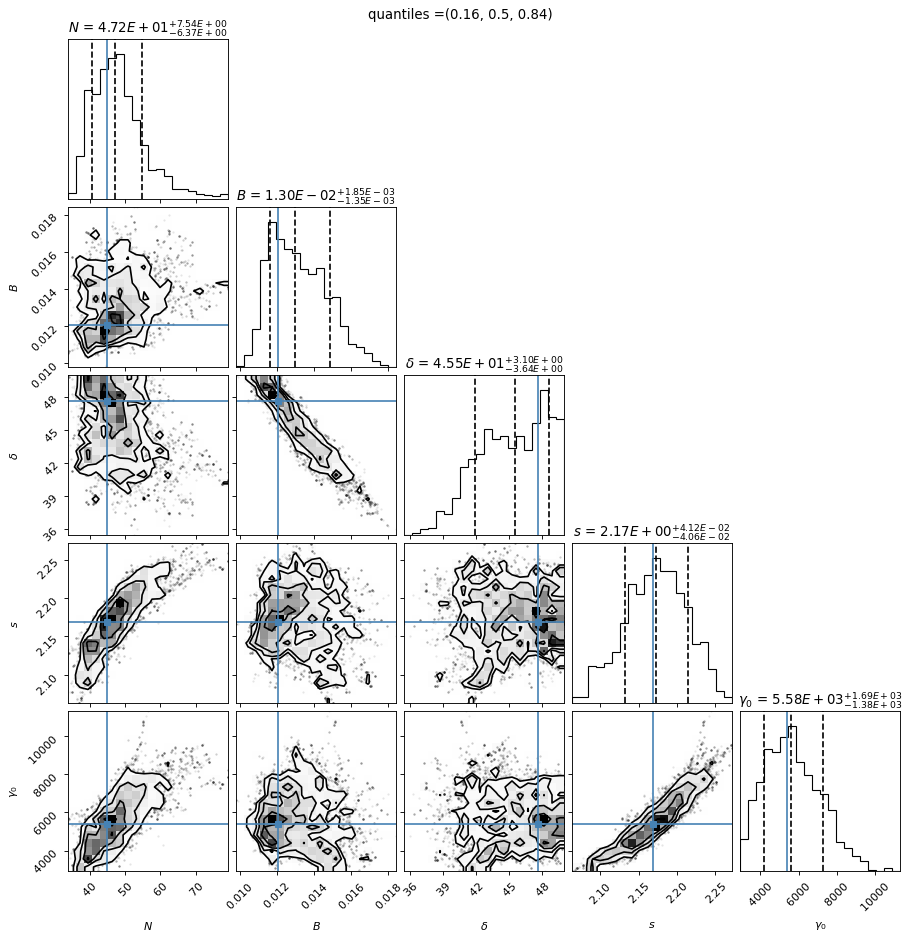

In [48]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 80
f=mcmc.corner_plot(quantiles=(0.16, 0.5, 0.84),title_kwargs=dict(fontsize=12),title_fmt=".2E",use_math_text=True)

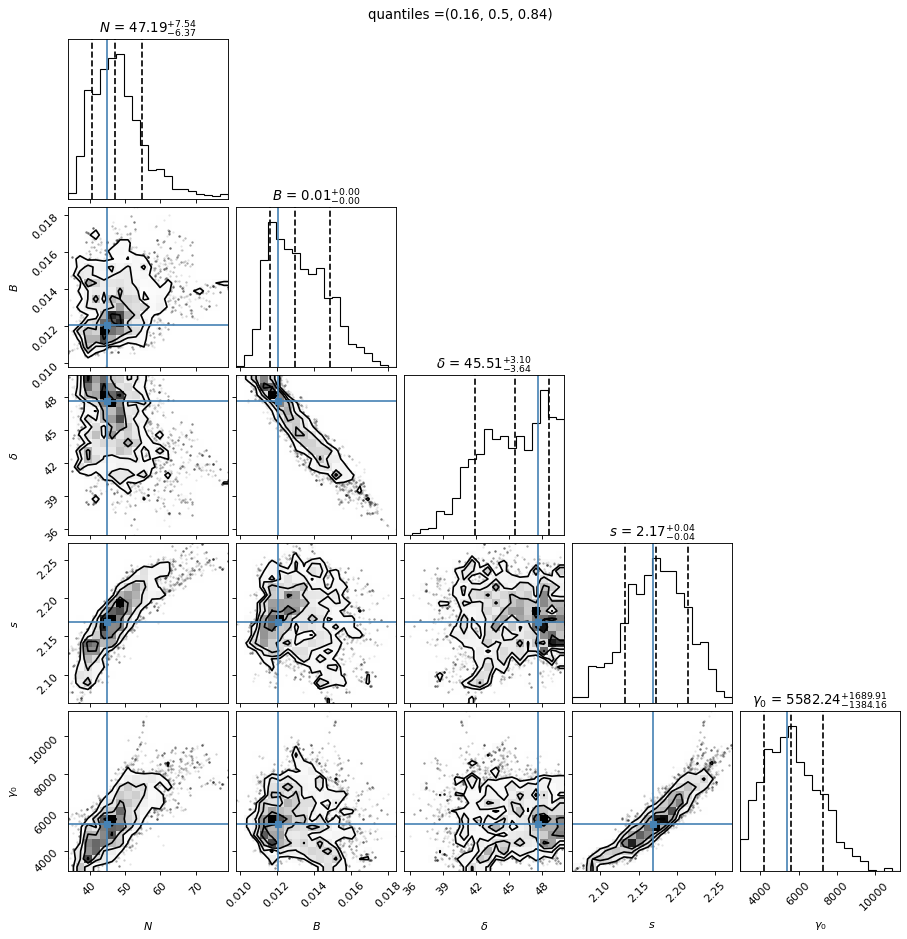

In [49]:
f=mcmc.corner_plot()

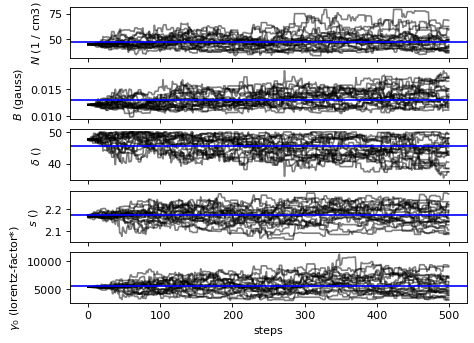

In [50]:
f=mcmc.plot_chain(log_plot=False)

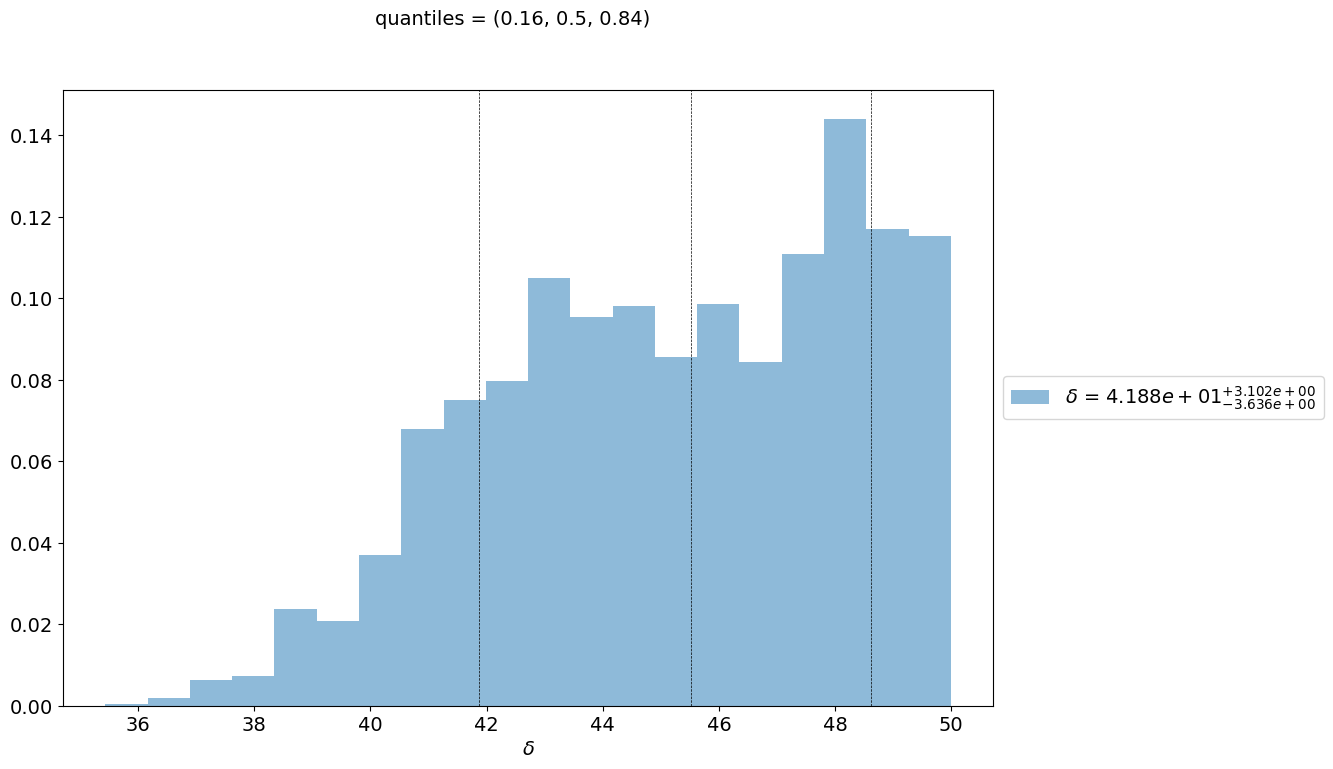

In [51]:
f=mcmc.plot_par('beam_obj')

## Save and reuse MCMC

In [52]:
mcmc.save('mcmc_sampler.pkl')

In [53]:
from jetset.mcmc import McmcSampler
from jetset.data_loader import ObsData
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs

sed_data=ObsData.load('Mrk_501.pkl')

ms=McmcSampler.load('mcmc_sampler.pkl')

===> setting C threads to 12
===> setting C threads to 12


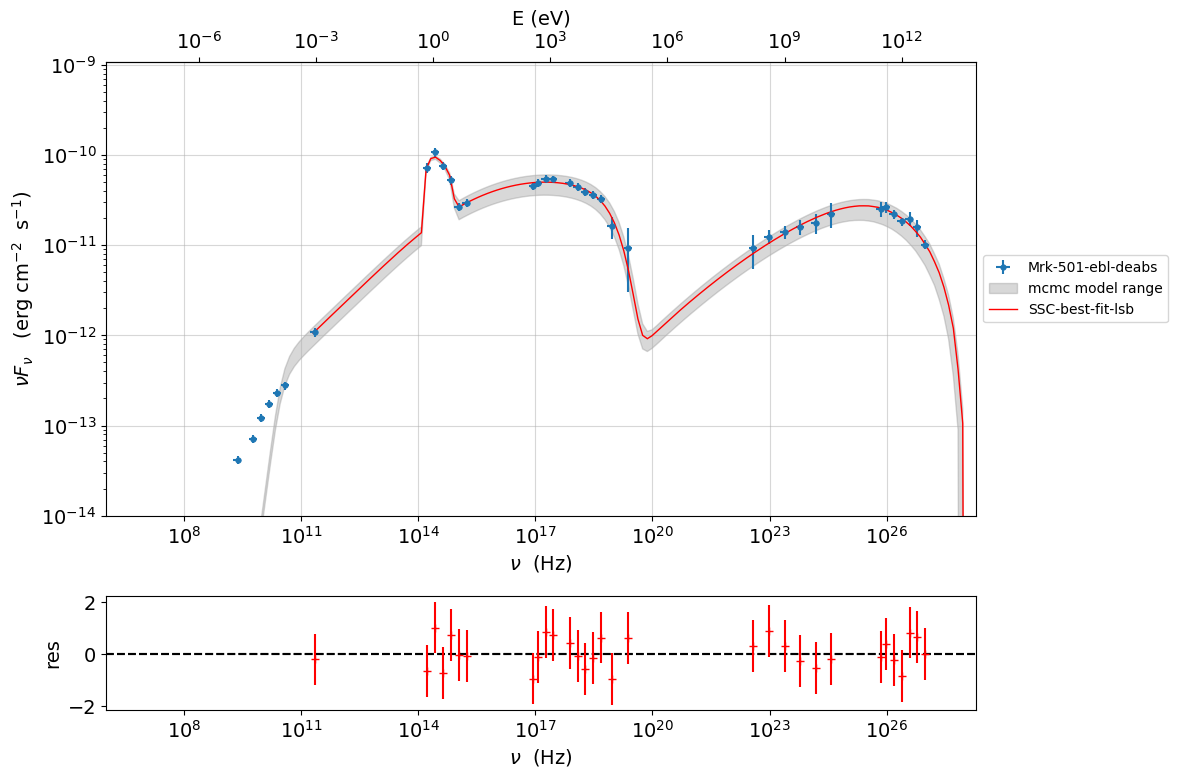

In [54]:
ms.model.nu_min=1E6
ms.model.jet_leptonic.nu_min=1E6
p=ms.plot_model(sed_data=sed_data,fit_range=[2E11, 2E28],size=100)
p.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

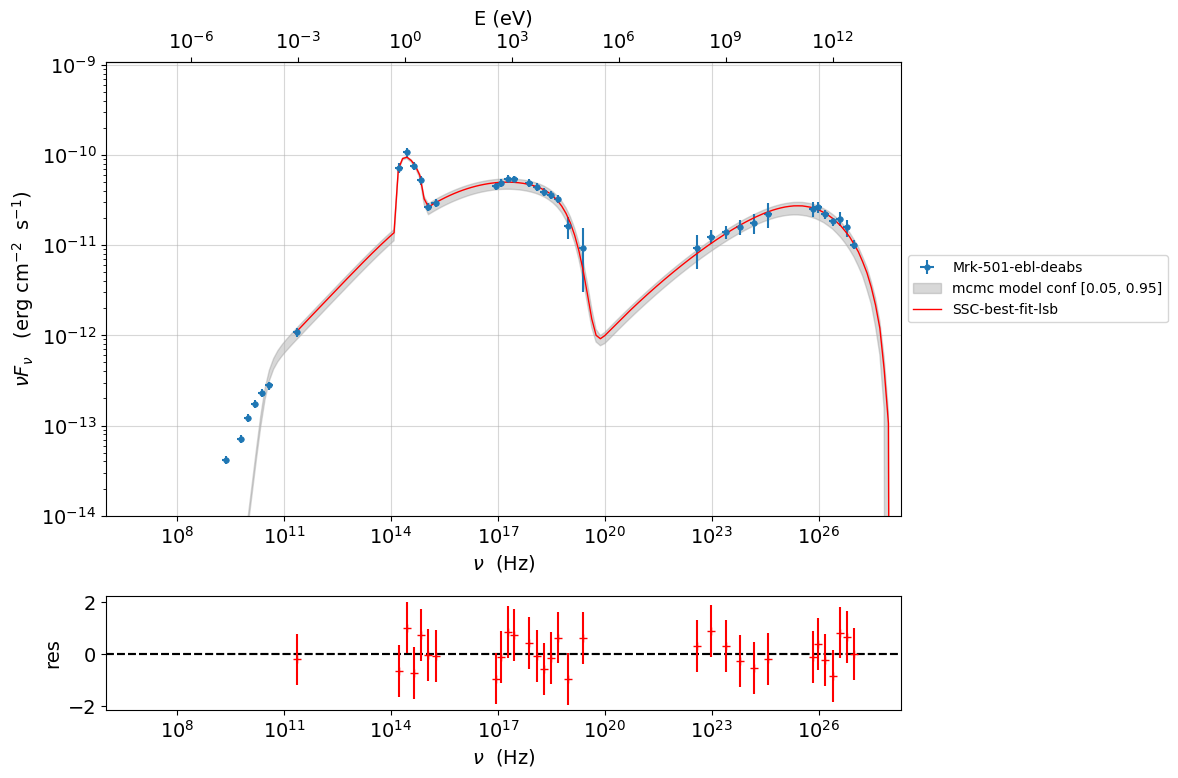

In [55]:
p=ms.plot_model(sed_data=sed_data,fit_range=[2E11, 2E28],quantiles=[0.05,0.95])
p.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

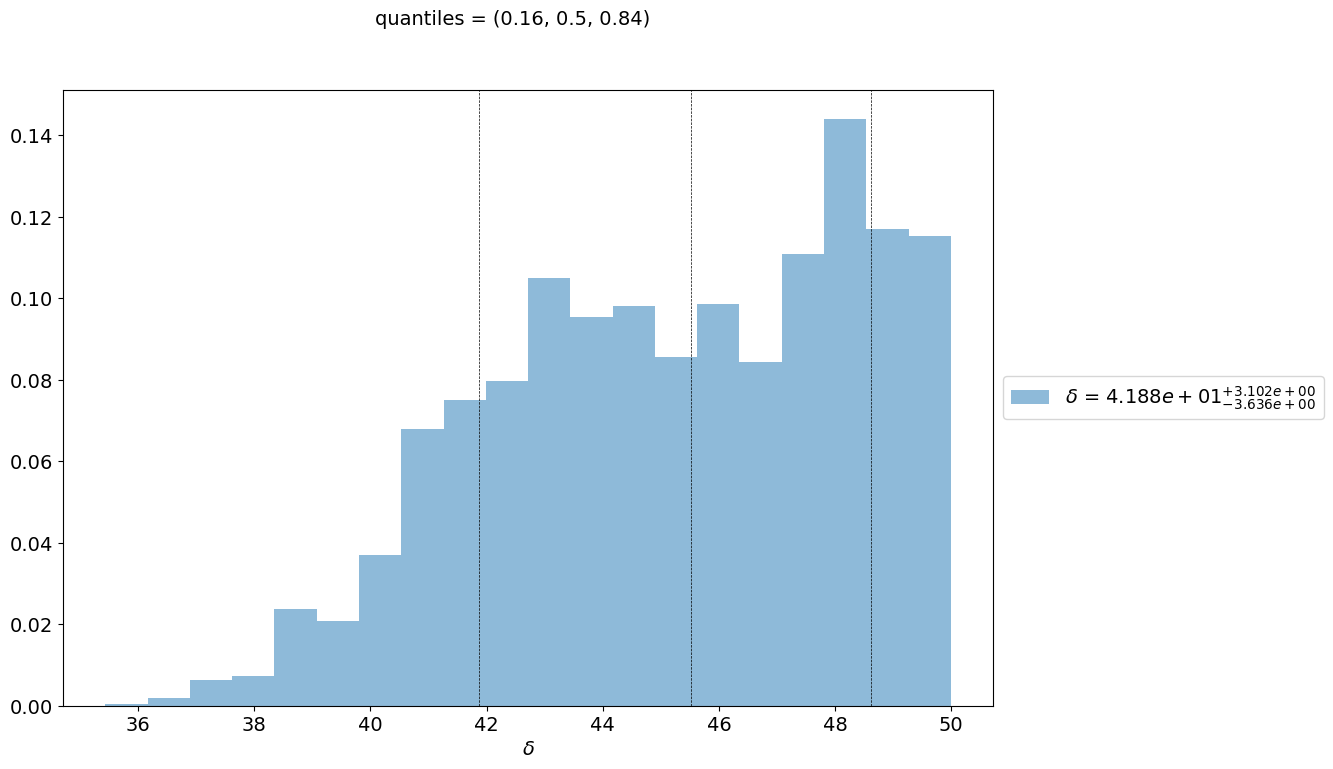

In [56]:
f=ms.plot_par('beam_obj',log_plot=False)


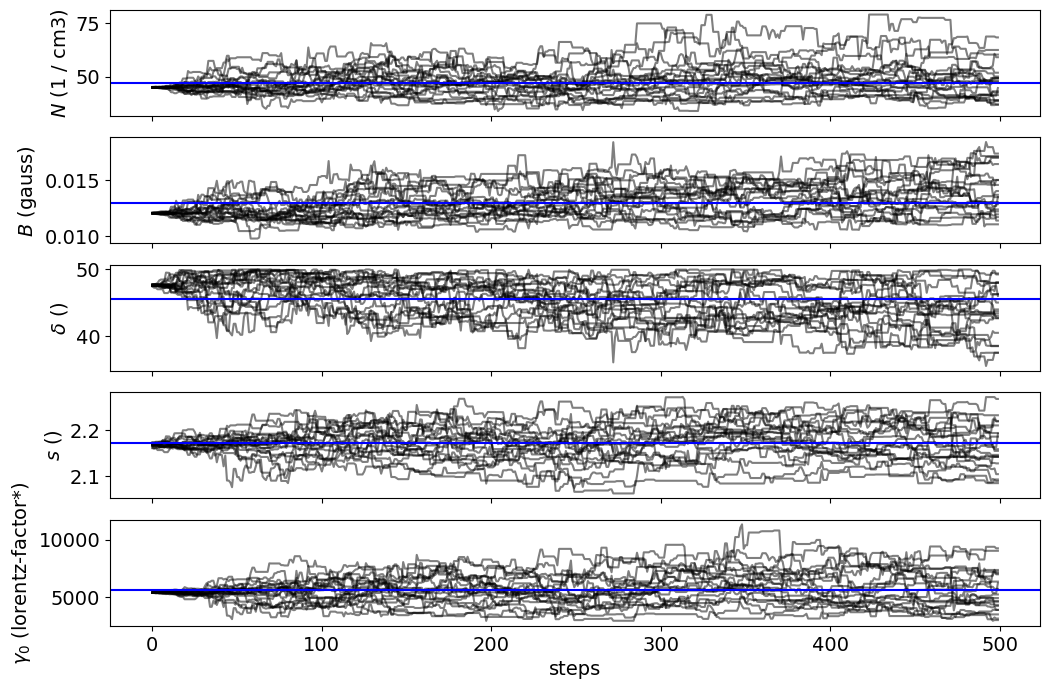

In [57]:
f=ms.plot_chain(log_plot=False)